## Image classification  - Kaggle Dog Breeds

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dog-breed-identification/"

In [5]:
samp_sub_df = pd.read_csv(f'{PATH}sample_submission.csv')

In [6]:
samp_sub_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## The dataset 
Sometimes datasets are provided with a csv reference to the lables instead of a sorted set of directories, so we first tell it where this reference file is located and then read the file into a pandas dataframe to investigate

In [5]:
# specify labels.csv loction and read in to dataframe
label_csv = f'{PATH}labels.csv'
labels_df = pd.read_csv(label_csv)

# create index for validation set
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

Take a look at the labels dataframe. Sometimes the files contain the file extention on the end. In this case, they havent

In [6]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


we then check to see how many of each class is in the dataset. this is to ensure that the dataset is relativly normally distributed. If there is a huge skew in the distribution, one method is to simply create copies the less represented class images

In [ ]:
labels_df.pivot_table(index= 'breed', aggfunc = len).sort_values('id', ascending = False)

## Create validation set index
When being provided with a csv reference file, the data isnt split into a validation set. So we create a set of indexes below to ensure we have some validation images for training

In [7]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

## Our model

In [21]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [8]:
# Model Parameters
arch=resnet34 # model architecture to use
sz=224 # image size
bs=64 # mini-batch size

In [9]:
# Data Augementation/Transformation Settings
tfms = tfms_from_model(arch, # pass in architecture
                       sz, # image size
                       aug_tfms=transforms_side_on, # side on for normal images
                       max_zoom=1.1)

In [10]:
# Data Configuration
data = ImageClassifierData.from_csv(path = PATH,
                                    folder ='train', # name of the folder where the training images are
                                    csv_fname = label_csv, # path to the label reference file
                                    val_idxs = val_idxs, # validation index for spliting out validation set
                                    suffix = '.jpg', # suffix to add if label reference doesnt contain
                                    test_name = 'test', # name of the folder where test images are
                                    tfms = tfms, # transformations to apply
                                    bs = bs #mini batch size
                                   )

In [11]:
# Create Learner
learn = ConvLearner.pretrained(arch,
                               data,
                               precompute=True)

In [26]:
# use learn.lr_find to find the optimal learning rate
lrf = learn.lr_find()

 86%|████████▌ | 110/128 [00:02<00:00, 54.23it/s, loss=21.3]


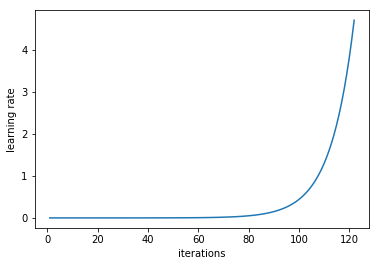

In [27]:
#plot learing rate
learn.sched.plot_lr()

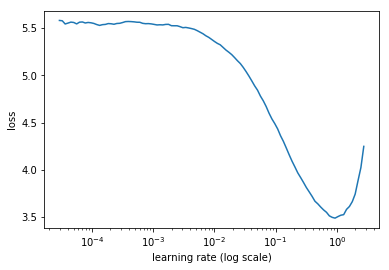

In [28]:
#plot learing rate
learn.sched.plot()

In [29]:
#Fit learner with a few epochs
learn.fit(0.1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.254337   0.708093   0.786693  
    1      0.749476   0.600218   0.813112                    



[array([0.60022]), 0.813111545754972]

In [31]:
learn.precompute=False

In [32]:
learn.fit(0.1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.635668   0.550861   0.830235  
    1      0.592567   0.524257   0.836595                    
    2      0.559942   0.525095   0.839041                    



[array([0.52509]), 0.8390410956571247]

In [33]:
learn.save('224_lastlayer')

In [34]:
learn.load('224_lastlayer')

In [36]:
learn.unfreeze()

In [37]:
lr=np.array([1e-4,1e-3,1e-2])

In [38]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.61412    0.552782   0.828767  
    1      0.532896   0.536419   0.835616                    
    2      0.432408   0.520609   0.841487                    
    3      0.433138   0.534932   0.834149                    
    4      0.377415   0.55468    0.833659                    
    5      0.329226   0.540301   0.841977                    
    6      0.29624    0.536569   0.838552                    



[array([0.53657]), 0.8385518588665181]

In [40]:
learn.save('224_all')

In [41]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [42]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [43]:
accuracy_np(probs, y)

0.863013698630137

## Analyzing results

### Confusion matrix 

In [44]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[16  0  0 ...  0  0  0]
 [ 0 21  0 ...  0  0  0]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 13]]


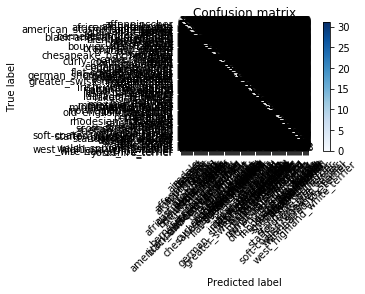

In [46]:
plot_confusion_matrix(cm, data.classes)